<a href="https://colab.research.google.com/github/AdiJainS/Decible-Duel/blob/main/Copy_of_DecibelDuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow
# !pip install keras-cv

In [6]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **READING DATA**

In [8]:
import os
import pandas as pd
import librosa
import numpy as np

def load_dataset(root_dir, sr=16000):
    X, y = [], []
    classes = sorted(os.listdir(root_dir))  # 5 subfolders

    for label, class_name in enumerate(classes):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if file.endswith(('.wav', '.mp3')):
                path = os.path.join(class_path, file)
                signal, _ = librosa.load(path, sr=sr)
                signal, _ = librosa.effects.trim(signal)
                X.append(signal)
                y.append(label)
    return X, np.array(y), classes


# creating training path
audio_train_path = "/content/drive/MyDrive/the-frequency-quest/train/train"
X, y, classes = load_dataset(audio_train_path)

# Create a pandas DataFrame to store the data and labels
music_data = pd.DataFrame({'audio_signal': X, 'class_id': y})

# Class id / class name
class_mapping = {i: class_name for i, class_name in enumerate(classes)}
music_data['class'] = music_data['class_id'].map(class_mapping)

display(music_data.head())

,audio_signal,class_id,class
0,"[-0.0019799368, -0.0021747933, -8.6987486e-05,...",0,dog_bark
1,"[0.01361015, 0.023458797, 0.021369603, 0.02013...",0,dog_bark
2,"[-0.010477142, -0.01547415, -0.009145305, -0.0...",0,dog_bark
3,"[0.014420046, 0.011795968, -0.0075576827, -0.0...",0,dog_bark
4,"[-0.0011533772, -0.0014374352, -0.0005228196, ...",0,dog_bark


# **Making Predictions on Test Data**

In [9]:
import os

audio_train_path = "/content/drive/MyDrive/the-frequency-quest/train/train"
audio_files_found = False

for root, dirs, files in os.walk(audio_train_path):
    for file in files:
        if file.endswith(('.wav', '.mp3')):
            print(os.path.join(root, file))
            audio_files_found = True

if not audio_files_found:
    print(f"No audio files (.wav or .mp3) found in {audio_train_path} or its subdirectories.")

/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108638-9-0-6.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108638-9-0-2.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/107653-9-0-7.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108357-9-0-27.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/110868-9-0-15.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108638-9-0-5.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108041-9-0-2.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/105425-9-0-14.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/107653-9-0-12.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/101848-9-0-9.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street_music/108041-9-0-6.wav
/content/drive/MyDrive/the-frequency-quest/train/train/street

# **Feature Extraction and Database Building**
MFCC - Mel frequency cepstral coefficients. Extraction technique widely used in speech and audio processing for tasks like speech recognition, speaker identification, and music analysis.

MFCCs role -

1.Signal analysis - It breaks down complex signals into simpler forms repr rate and characterisits of sound waves

2.Frequency transform - humans do not understand freq on a linear scale . Hnece mere mel freq. is used which rounds off to human auditory systems

3.Cepstral repr - mel freq --- > cepstrum where audios signal pitch is seperated form slow variations (timbre) carrying the most imp info regarding the audio   ( ie . most important part of audio is seperated )

features related to MFCC

1.Windowing ----> stops spectral leakages , or sudden jumps in amplitudes of audio .

2.FFT ---->converts time domained signal of each framed signal into freq domain.

3.Mel-filterblank ---- >   Frequency Band seperation - Divided FFT output into these bands capturing E level of each band

4.Log mel-spectrum - ie logartithmic compression  -- By taking the logarithm of the output from the Mel-filterbank, the dynamic range of the signal is compressed.

In [10]:
from sklearn.preprocessing import StandardScaler


# The features should have a consistent shape after extraction.
if 'extracted' in globals() and extracted:
    X_features = np.array([item[0] for item in extracted])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)


In [11]:
from tqdm import tqdm   #tqdm is a Python library used to create fast, extensible progress bars for loops and iterables.
extracted = []


for index_num, row in tqdm(music_data.iterrows()):

    audio = row["audio_signal"]
    final_class_labels = row["class"]


    # need to adjust this based on how your audio was loaded initially
    sample_rate = 16000 # Example sample rate

    # feature extr.
    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    # feature scaling
    scaled_feature = np.mean(feature.T, axis=0)
    # list storing
    extracted.append([scaled_feature, final_class_labels])

3454it [00:24, 143.27it/s]


In [12]:
from sklearn.model_selection import train_test_split

# Convert extracted features and labels into numpy arrays
extracted_features = np.array([item[0] for item in extracted])
extracted_labels = np.array([item[1] for item in extracted])

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    extracted_features,
    extracted_labels,

    random_state=24
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,

    random_state=24
)

print("Data splitting complete.")
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Validation features shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)
print("Validation labels shape:", y_val.shape)

Data splitting complete.
Training features shape: (2590, 128)
Testing features shape: (216, 128)
Validation features shape: (648, 128)
Training labels shape: (2590,)
Testing labels shape: (216,)
Validation labels shape: (648,)


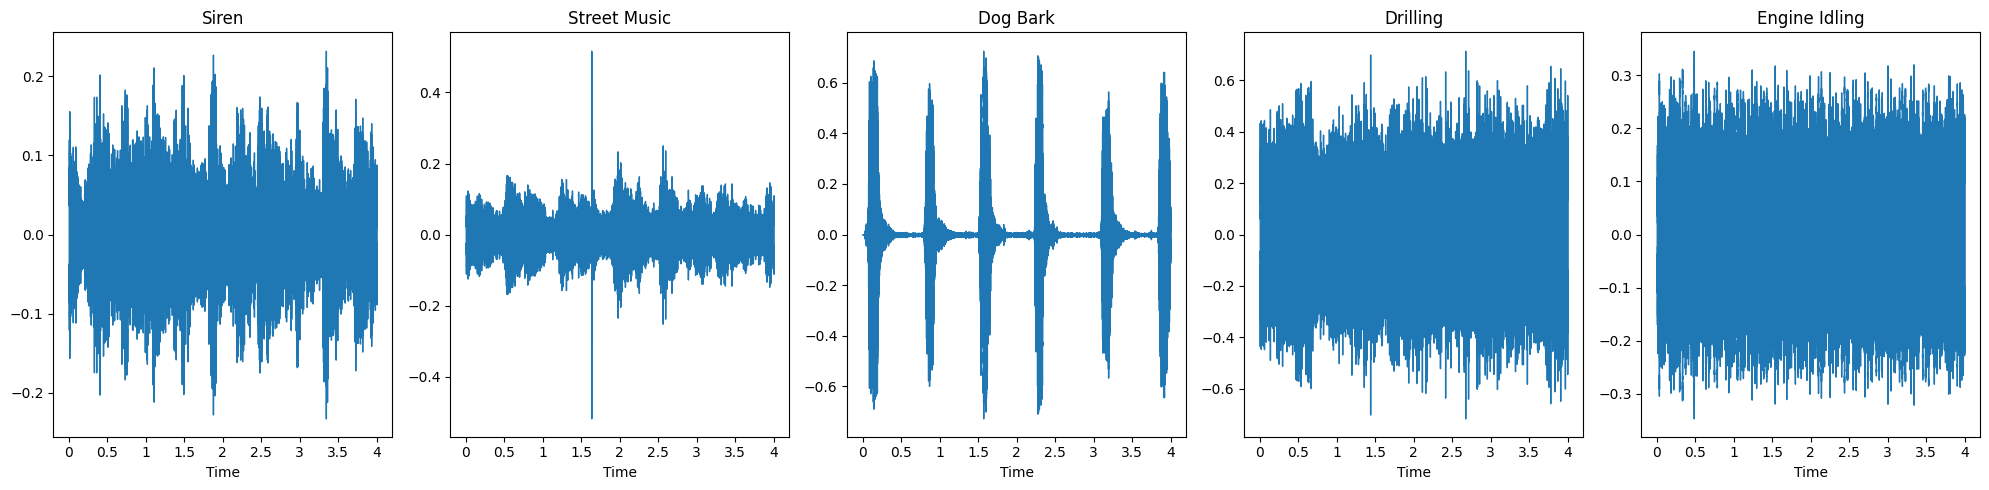

In [13]:
import matplotlib.pyplot as plt
# Loading audio files
siren, siren_sr = librosa.load(r"/content/drive/MyDrive/the-frequency-quest/train/train/street_music/101848-9-0-1.wav")
street_music, street_music_sr = librosa.load(r"/content/drive/MyDrive/the-frequency-quest/train/train/street_music/101848-9-0-9.wav")
dog_bark, dog_bark_sr = librosa.load(r"/content/drive/MyDrive/the-frequency-quest/train/train/dog_bark/100795-3-0-0.wav")
drilling, drilling_sr = librosa.load(r"/content/drive/MyDrive/the-frequency-quest/train/train/drilling/103199-4-0-5.wav")
engine_idling, engine_idling_sr = librosa.load(r"/content/drive/MyDrive/the-frequency-quest/train/train/engine_idling/102857-5-0-12.wav")

# Create subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5), sharex=True)

librosa.display.waveshow(siren, sr=siren_sr, ax=ax1)
ax1.set_title("Siren")

librosa.display.waveshow(street_music, sr=street_music_sr, ax=ax2)
ax2.set_title("Street Music")

librosa.display.waveshow(dog_bark, sr=dog_bark_sr, ax=ax3)
ax3.set_title("Dog Bark")

librosa.display.waveshow(drilling, sr=drilling_sr, ax=ax4)
ax4.set_title("Drilling")

librosa.display.waveshow(engine_idling, sr=engine_idling_sr, ax=ax5)
ax5.set_title("Engine Idling")

plt.tight_layout()
plt.show()

# MODEL SELECTION

There are many models on which we can train data on . ANN , CNN etc.

ANN - Artificial Neural Network -- a computer system modeled after the human brain that learns from data to perform tasks like classification and pattern recognition.

CNN - Convultional Neural Network --  a type of machine learning model primarily used for image recognition that uses special layers to automatically learn and detect patterns in images, such as edges, textures, and shapes

CNN > ANN in this case. (CNN IS A SPECIALIZED ANN)

In short , use of the CNN features used here ---
Dense - fully connected layers , used in classification / regression

Conv1d - 1D layer used for time series ,audio signals ,freq

conv2d - 2D layer , used for imgs /spectrograms

MaxPooling1D / MaxPool2D - Pooling layers

Reduce the spatial/temporal dimension after convolution to extract key features.

Dropout - Helps preventing overfitting by randomly dropping neurons.

flatten - convert all layers into dense layers


In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

### Implement data augmentation

Apply data augmentation techniques to the training data to increase its size and variability, which can help the model generalize better and reduce overfitting.

useful for smaller datasets and is a common technique in fields like CV, where transformations like flipping, rotating, and cropping are applied to existing images to create new, synthetic data.

IT INCREASES ACCURACY BY ----

1.INCREASING DATA DIVERSITY WHICH HELPS IN GENERALIZATION

2.REDUCES OVERFITTING AS IT BECOMES TOUGH FOR MODEL TO MEMORIZE THE DATA

3.IMPORVES ROBUSTNESS AS THERE ARE VARIATIONS IN DATA WHICH HELPS IN TRAINING

# **Structure of this Augmentation of data**
We mixed audio signals , ie created a new feature mixing it by taking a ratio , ie signal A - > .6 , signal B - > .4 , creating more variations.

We set the parameters by defining augment_audio -
  noise_factor : Factor to scale the added noise.

  shift_factor : Factor to determine the maximum shift in time.

  pitch_factor : Factor to determine the maximum pitch shift.

 i.   noise = np.random.randn(len(augmented_signal))
    augmented_signal = augmented_signal + noise_factor * noise            
 ---> to add some background noise so that more variations of sound can be identified and training can become more rigorous

 ii.   shift = int(sr * shift_factor * random.uniform(-1, 1))
    augmented_signal = np.roll(augmented_signal, shift)
--->shifts the audio samples along an axis (np.roll())in random amounts at any time
understanding roll by an example --->
signal = [2,3,4,5]

np.roll(signal,2) = [4,5,2,3]  but in producing audio we dont want the last part of audio to come in the beginning , hence we have to mark em as zero .

corrected ---> np.roll(signal ,2) =[0,0,2,3]

iii. also we are trying to vary the speech a little up and down , to create more variations.

iv. Now we need to take one max length of audio and keeping it as a reference , trim or fix all the other audios of the same length

v.Now we applied augmentation 2+ the original sample (1+2=3)

after padding , storing data -

vi.We need to extract the features . as raw audiofomrms tougher to understand by the CNN ,it is first converted to MFCC .

    librosa.feature.mfcc   
  ---> extracts MFCCs , each clip 128 D vectors

In [15]:
import random
import librosa
import numpy as np
from tqdm import tqdm

def mix_audio(signal1, signal2, ratio=0.6):
    """
    Mix two audio signals according to the ratio.
    ratio=0.6 → 60% signal1 + 40% signal2
    """
    min_len = min(len(signal1), len(signal2))
    s1 = signal1[:min_len]
    s2 = signal2[:min_len]

    mixed = (ratio * s1) + ((1 - ratio) * s2)

    # Avoid clipping
    if np.max(np.abs(mixed)) > 0:
        mixed = mixed / np.max(np.abs(mixed))

    return mixed

def augment_audio(signal, sr, noise_factor=0.0005, shift_factor=0.5, pitch_factor=0.7):
    """

  noise_factor : Factor to scale the added noise.
  shift_factor : Factor to determine the maximum shift in time.
  pitch_factor : Factor to determine the maximum pitch shift.

    """
    augmented_signal = signal.copy()

    # Add noise
    noise = np.random.randn(len(augmented_signal))
    augmented_signal = augmented_signal + noise_factor * noise

    # Time shifting
    shift = int(sr * shift_factor * random.uniform(-1, 1))
    augmented_signal = np.roll(augmented_signal, shift)
    if shift > 0:
        augmented_signal[:shift] = 0
    else:
        augmented_signal[shift:] = 0

    # Pitch shifting
    # if the signal is long enough
    if len(augmented_signal) > 0:
        steps = random.uniform(-pitch_factor, pitch_factor)
        augmented_signal = librosa.effects.pitch_shift(augmented_signal, sr=sr, n_steps=steps)

    return augmented_signal

# Determine a fixed length for padding/truncation

max_len = max(len(signal) for signal in X)


def pad_or_truncate(signal, max_len):
    """Pads or truncates an audio signal to a fixed length."""
    if len(signal) > max_len:
        return signal[:max_len]
    elif len(signal) < max_len:
        pad_width = max_len - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    else:
        return signal


# Store original and augmented data
augmented_X_train_signals = []
augmented_y_train_labels = []

# Add original data
for i in range(len(X)):  # stores all original padded data
    augmented_X_train_signals.append(pad_or_truncate(X[i], max_len))
    augmented_y_train_labels.append(y[i])


# Apply augmentation ( 2 times per original sample)
num_augmentations_per_sample = 2
sample_rate = 16000

for i in tqdm(range(len(X))):
    original_signal = X[i]
    original_label = y[i]

    for _ in range(num_augmentations_per_sample):
        augmented_signal = augment_audio(original_signal, sample_rate)
        augmented_X_train_signals.append(pad_or_truncate(augmented_signal, max_len))
        augmented_y_train_labels.append(original_label)

# Convert augmented lists back to numpy arrays
augmented_X_train_signals = np.array(augmented_X_train_signals)
augmented_y_train_labels = np.array(augmented_y_train_labels)


print(f"Original training data size: {len(X)}")
print(f"Augmented training data size (including original): {len(augmented_X_train_signals)}")
print(f"Fixed audio signal length: {max_len}")


# Feature extraction for augmented data
augmented_extracted = []
for i in tqdm(range(len(augmented_X_train_signals))):
    audio = augmented_X_train_signals[i]
    label_id = augmented_y_train_labels[i]
    label_name = class_mapping[label_id] # Get the class name from the id

    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    scaled_feature = np.mean(feature.T, axis=0)
    augmented_extracted.append([scaled_feature, label_name])

# Convert augmented extracted features and labels into numpy arrays
augmented_extracted_features = np.array([item[0] for item in augmented_extracted])
augmented_extracted_labels = np.array([item[1] for item in augmented_extracted])


# Update X_train and y_train with augmented data
#X_train --- > feature
#Y_train --->class lables
X_train = augmented_extracted_features
y_train = augmented_extracted_labels



100%|██████████| 3454/3454 [02:42<00:00, 21.23it/s]


Original training data size: 3454
Augmented training data size (including original): 10362
Fixed audio signal length: 64127


100%|██████████| 10362/10362 [01:20<00:00, 129.34it/s]


# ADDING BATCH NORMALIZATION LAYER --- > INC IN LAYERS CAN POTENTIALLY INCREASE ACCURACY AND LION OPTIMIZER

It increases accuracy as it normalizises the effects , helping in increasing LR , leading to mroe stable and faster training process

Lion optimizers ----> better than adam .
It is a SGD method which uses sign oprator to control the magnitude .lion is more efficient than Adam as it only keeps memory of Adam.

Lion optimizers need more time to learn , hence 10^-6 order to LR is better as comapred to normal LR of adam as 10^-3 orders as it will give high value errors.
Here but Adam is giving more accuracy.

AdamW optimizer also used , but still accuracy cannot be increased .

    layers.Conv1D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

conv1d ---> applies 32 feature detectors for each of length 3 samples

ReLu --->converts negative outputs to 0 and prevents vanishing of gradients

Batch Normalization --->stab. training mean =0 var =1 per batch

maxpooling --->removes temporal res by half stride =2 , Keeps the strongest activation (most important feature) in each 2-sample window.

lets understand it by an example .
1D map --> [1,2,3,4,5,6]  , layers.MaxPooling1D(2),

here pools of 2 are created . [1,2] ,[3,4] ,[5,6] . Max vals of pools selected . 2,4,6 . Hence here we are keeping the strongest activation(or the maximum values) and the most prominent feature.

    layers.GlobalAveragePooling1D(),

---> Converts each feature map (from 256 filters) into one single value (mean across time).

    layers.Dense(128, activation='relu'),

---> learns non-linear comb of extracted features

    layers.Dropout(0.4),

---> dropping 40 % of neurons

    layers.Dense(5, activation='softmax')

---> 5 target classes . softmax converts raw scores into prob summing to 1 and model predicts most likely class


In [16]:
from tensorflow.keras.optimizers import Adam, Lion
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    #32 karnels , 3 sliding windows , activ. func , size of shape eg if shape size is 1000,50 then it will be 50,1 50 times steps per feature
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.GlobalAveragePooling1D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4), # reduce overfitting  , when neurons are dropped , model cannot rely on specific neurons to memorize the data .
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy means your y_train labels are integers , not one-hot vectors.
              metrics=['accuracy'])
# model.compile(optimizer=Lion(learning_rate=5e-6),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()
# # import numpy as np
# # from sklearn.preprocessing import StandardScaler
# # from tensorflow.keras import layers, models
# # from tensorflow.keras.optimizers import AdamW
# # from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# # # 1. NORMALIZE INPUT DATA  (MOST IMPORTANT)
# # scaler = StandardScaler()

# # X_train_scaled = scaler.fit_transform(X_train)
# # X_test_scaled  = scaler.transform(X_test)

# # # Reshape for Conv1D
# # X_train_scaled = X_train_scaled.reshape(-1, X_train.shape[1], 1)
# # X_test_scaled  = X_test_scaled.reshape(-1, X_test.shape[1], 1)


# # model = models.Sequential([
# #     layers.Conv1D(32, 5, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
# #     layers.BatchNormalization(),
# #     layers.MaxPooling1D(2),
# #     layers.Dropout(0.2),

# #     layers.Conv1D(64, 5, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
# #     layers.MaxPooling1D(2),
# #     layers.Dropout(0.2),

# #     layers.Conv1D(128, 5, padding='same', activation='relu'),
# #     layers.BatchNormalization(),
# #     layers.MaxPooling1D(2),
# #     layers.Dropout(0.3),

# #     layers.GlobalAveragePooling1D(),
# #     layers.Dense(256, activation='relu'),
# #     layers.Dropout(0.4),
# #     layers.Dense(5, activation='softmax')   # 5 classes
# # ])

# # model.compile(
# #     optimizer=AdamW(learning_rate=3e-4, weight_decay=1e-4),
# #     loss='sparse_categorical_crossentropy',
# #     metrics=['accuracy']
# # )

# # #Callbacks

# # callbacks = [
# #     EarlyStopping(patience=15, restore_best_weights=True),
# #     ReduceLROnPlateau(factor=0.3, patience=5)
# # ]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# ResNet-9
is a compact version of the original ResNet architecture.
It uses residual connections (skip connections) to help the network learn deeper patterns without vanishing gradients.

In this method of RESNET , we need to solve problem of exploding gradient . Hence to fix this , residual blocks were introduced which uses skip connections which connects the layers of activation by skipping connections .The skip connection connects layers again by skipping some layers to form residual block.

Pros of ResNet --->
---> If any layer gets hurt in performance then by regularization it will be skipped resulting in a very deep NN

This method was first tested on a CIFAR 10 dataset ( collection of images that are commonly used to train machine learning and computer vision algorithms) over 100s of layers

Tried adding it but it did not work properly as accuracy became lower .



In [17]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras import layers, models, Input
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import AdamW

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

# # reshape for Conv1D
# X_train_scaled = X_train_scaled.reshape(-1, X_train.shape[1], 1)
# X_test_scaled  = X_test_scaled.reshape(-1, X_test.shape[1], 1)


# #residual block
# def ResBlock(x, filters):
#     shortcut = x

#     x = layers.Conv1D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv1D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     # projection if channel mismatch
#     if shortcut.shape[-1] != filters:
#         shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
#         shortcut = layers.BatchNormalization()(shortcut)

#     x = layers.Add()([x, shortcut])
#     x = layers.ReLU()(x)
#     return x


# def ResNet9_1D(input_shape, num_classes):

#     inputs = Input(shape=input_shape)

#     # Initial layer
#     x = layers.Conv1D(32, 7, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPooling1D(2)(x)

#     # 3 Residual Blocks
#     x = ResBlock(x, 32)   # Block 1
#     x = ResBlock(x, 64)   # Block 2
#     x = ResBlock(x, 128)  # Block 3

#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)

#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     return models.Model(inputs, outputs)



# model = ResNet9_1D((X_train.shape[1], 1), num_classes=5)


# model.compile(
#     optimizer=AdamW(learning_rate=3e-4, weight_decay=1e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )


# callbacks = [
#     EarlyStopping(patience=12, restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.3, patience=4)
# ]




# model.summary()




In [18]:

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

y_train_encoded = np.array([list(class_mapping.keys())[list(class_mapping.values()).index(label)] for label in y_train])
y_val_encoded = np.array([list(class_mapping.keys())[list(class_mapping.values()).index(label)] for label in y_val])


history = model.fit(
    X_train_reshaped, y_train_encoded,
    validation_data=(X_val_reshaped, y_val_encoded),
    epochs=100,
    batch_size=64
)




Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.6008 - loss: 1.0453 - val_accuracy: 0.4475 - val_loss: 1.2526
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8607 - loss: 0.4289 - val_accuracy: 0.8457 - val_loss: 0.4835
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9125 - loss: 0.2635 - val_accuracy: 0.9321 - val_loss: 0.2195
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9381 - loss: 0.1914 - val_accuracy: 0.9444 - val_loss: 0.1864
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9542 - loss: 0.1464 - val_accuracy: 0.9645 - val_loss: 0.1482
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9629 - loss: 0.1125 - val_accuracy: 0.9614 - val_loss: 0.1531
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9742 - loss: 0.0851 - val_accuracy: 0.9630 - val_loss: 0.1764
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9741 - loss: 0.0786 - 

In [19]:
# Reshapeing the training data for evaluation
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Use the integer-encoded training labels
loss, accuracy = model.evaluate(X_train_reshaped, y_train_encoded)

print(loss, accuracy)

324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0047
0.0061061629094183445 0.998262882232666


# TESTING

We have trained the data , now we have to test randomly

If max_len is already defined it remains .
16000*3 = 48K samples.

    if len(signal) > max_len:
        return signal[:max_len]
    elif len(signal) < max_len:
        pad_width = max_len - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    else:
        return signal
---> ensuring every input waveform is of max_len samples , if longer then truncates , if shorted then pads w/ 0

    scaled_feature = np.mean(mfccs.T, axis=0)
Transposes MFCCs to shape (time_frames, n_mfcc) then averages across time --> one 1D vector of length n_mfcc

In [20]:
import os
import numpy as np
import pandas as pd
import librosa


audio_test_path = "/content/drive/MyDrive/the-frequency-quest/test/test"
output_csv_path = "/content/drive/MyDrive/the-frequency-quest/submission.csv"
sr = 16000
n_mfcc = 128
test_sample_limit = 740

try:
    max_len = max_len
except NameError:
    if 'X' in globals():
         max_len = max(len(signal) for signal in X)
    else:

         max_len = 16000 * 3


def pad_or_truncate(signal, max_len):
  #Pads truncates an audio signal to a fixed length
    if len(signal) > max_len:
        return signal[:max_len]
    elif len(signal) < max_len:
        pad_width = max_len - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    else:
        return signal


def pipeline(filename, model, class_mapping, sr=16000, n_mfcc=128, max_len=max_len):

    signal, _ = librosa.load(filename, sr=sr)
    processed_signal = pad_or_truncate(signal, max_len)

    mfccs = librosa.feature.mfcc(y=processed_signal, sr=sr, n_mfcc=n_mfcc)
    scaled_feature = np.mean(mfccs.T, axis=0)
    reshaped_feature = scaled_feature.reshape(1, n_mfcc, 1)

    # PredictIONSSS
    prob = model.predict(reshaped_feature, verbose=0)[0]
    max_index = np.argmax(prob)
    predicted_class = class_mapping.get(max_index, "Unknown")
    return predicted_class

results = []

# # Listed all audio files
all_audio_files = sorted([f for f in os.listdir(audio_test_path) if f.endswith(('.wav', '.mp3'))])

 # Limit the number of files to process
files_to_process = all_audio_files[:test_sample_limit]

for file in files_to_process:
    file_path = os.path.join(audio_test_path, file)
    predicted_class = pipeline(file_path, model, class_mapping, sr=sr, n_mfcc=n_mfcc, max_len=max_len)
     # Keep the full filename including the extension
    results.append({"ID": file, "Class": predicted_class})
    print(f"{file} → {predicted_class}")


submission_df = pd.DataFrame(results)
submission_df.to_csv(output_csv_path, index=False)

print("Submission file created successfully!")
print(f"Saved to: {output_csv_path}")
display(submission_df.head())

100652-3-0-3.wav → dog_bark
101415-3-0-3.wav → dog_bark
101848-9-0-3.wav → street_music
101848-9-0-8.wav → street_music
102106-3-0-0.wav → dog_bark
102842-3-1-6.wav → dog_bark
102857-5-0-10.wav → engine_idling
102857-5-0-19.wav → engine_idling
102857-5-0-27.wav → engine_idling
102857-5-0-4.wav → engine_idling
102871-8-0-15.wav → siren
103199-4-2-2.wav → drilling
103199-4-2-4.wav → drilling
103199-4-4-0.wav → drilling
103249-5-0-10.wav → engine_idling
103249-5-0-13.wav → engine_idling
103249-5-0-17.wav → engine_idling
103249-5-0-5.wav → engine_idling
103249-5-0-6.wav → engine_idling
103258-5-0-19.wav → engine_idling
103357-4-0-1.wav → drilling
104625-4-0-21.wav → drilling
104817-4-0-5.wav → drilling
105088-3-0-11.wav → dog_bark
105088-3-0-8.wav → dog_bark
105289-8-0-1.wav → siren
105289-8-2-5.wav → dog_bark
105319-3-0-22.wav → dog_bark
106014-5-0-0.wav → engine_idling
106015-5-0-11.wav → engine_idling
106015-5-0-15.wav → engine_idling
106015-5-0-16.wav → engine_idling
106487-5-0-0.wav →

,ID,Class
0,100652-3-0-3.wav,dog_bark
1,101415-3-0-3.wav,dog_bark
2,101848-9-0-3.wav,street_music
3,101848-9-0-8.wav,street_music
4,102106-3-0-0.wav,dog_bark


# Evaluate the model on the test dataset

In [21]:
# Reshape the test data for evaluation
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert string test labels ----> integers using the class_mapping
y_test_encoded = np.array([list(class_mapping.keys())[list(class_mapping.values()).index(label)] for label in y_test])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9741 - loss: 0.1149 
Test Loss: 0.1217
Test Accuracy: 0.9676


In [22]:
from google.colab import files

files.download(output_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize training history

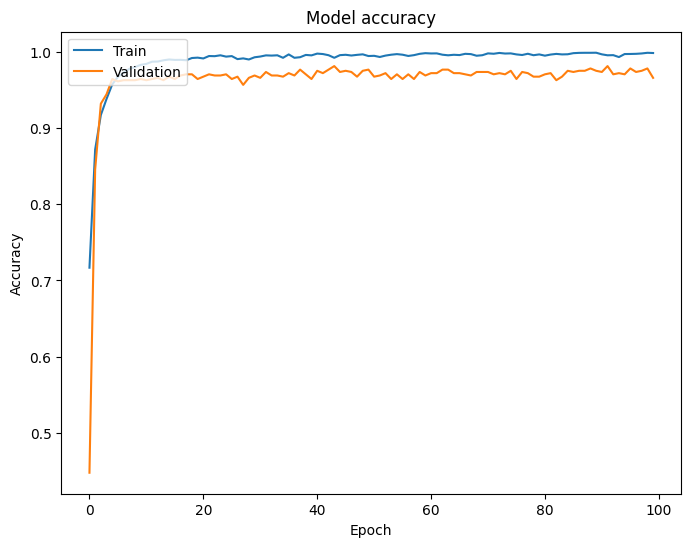

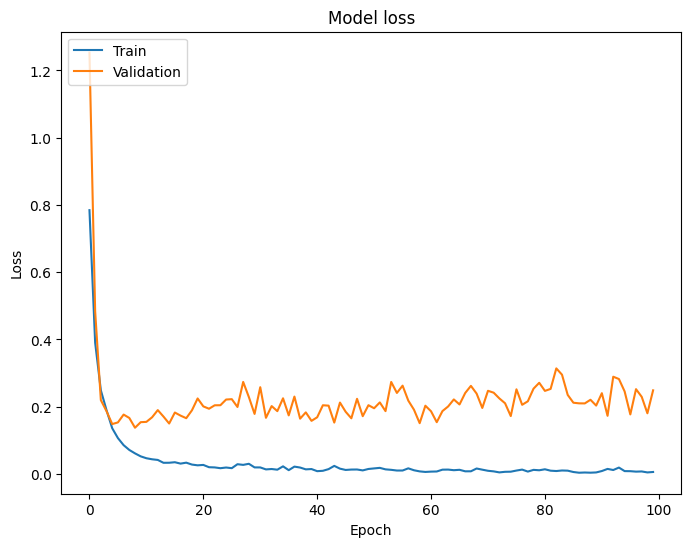

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()